# OPENTIS
## An Example with Alanine

Import Modules

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
import simtk.openmm as mm
from simtk.openmm import app
from simtk import unit
 
from openpathsampling.storage import Storage
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

import openpathsampling as paths

Radians to Degree conversion

In [2]:
deg = 3.14159265 / 180.0

Create an AlanineOpenMMSimulator for demonstration purposes

### Set simulation options and create a simulator object

In [3]:
template = paths.tools.snapshot_from_pdb("../data/Alanine_solvated.pdb")

{'_lazy': {<openpathsampling.netcdfplus.proxy.DelayedLoader object at 0x10a2951d0>: <openpathsampling.snapshot.Snapshot object at 0x106271210>}, 'is_reversed': True}
{'_lazy': {<openpathsampling.netcdfplus.proxy.DelayedLoader object at 0x10a2951d0>: <openpathsampling.snapshot.Snapshot object at 0x10f23a110>}, 'is_reversed': False}


In [4]:
storage = Storage(filename="trajectory.nc", template=template, mode='w')

Set up the OpenMM simulation

In [5]:
topology = paths.tools.to_openmm_topology(template)            

# Generated using OpenMM Script Builder
# http://builder.openmm.org

forcefield = app.ForceField(
    'amber96.xml',  # solute FF
    'tip3p.xml'     # solvent FF
)

# OpenMM System
system = forcefield.createSystem(
    topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers, 
    constraints=app.HBonds, 
    rigidWater=True, 
    ewaldErrorTolerance=0.0005
)

# OpenMM Integrator
integrator = mm.LangevinIntegrator(
    300*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds
)
integrator.setConstraintTolerance(0.00001)

# Engine options
options = {
    'nsteps_per_frame': 10
}

engine = paths.OpenMMEngine(
    template, 
    system,
    integrator,
    options
)

In [6]:
storage.save(engine)

And save the storage in a separate variable for convenience

In [7]:
paths.EngineMover.engine = engine

In [8]:
storage.set_caching_mode('lowmemory')

Equilibrate

In [9]:
engine.current_snapshot = engine.template
#engine.equilibrate(5)

Save equilibrated snapshot with index 0

In [10]:
storage.save(engine.current_snapshot);

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms

In [11]:
psi_atoms = [6,8,14,16]
psi = paths.CV_MDTraj_Function("psi", md.compute_dihedrals, indices=[psi_atoms])

phi_atoms = [4,6,8,14]
phi = paths.CV_MDTraj_Function("phi", md.compute_dihedrals, indices=[phi_atoms])

In [12]:
storage.save([psi, phi]);

{'_lazy': {<openpathsampling.netcdfplus.proxy.DelayedLoader object at 0x10a2951d0>: <openpathsampling.netcdfplus.proxy.LoaderProxy object at 0x1103d4c30>}, 'is_reversed': True}


### Volumes

This creates two states using a one-dimensional order parameter (called _Lambda_ in TIS terminology). A snapshot is in the State as long as the order parameter is with specific bounds. 

StateA is $\psi \in [-120, -30]$ and StateB is $\psi \in [100, 180]$

In [13]:
stateA = paths.CVRangeVolumePeriodic(
    collectivevariable=psi, 
    lambda_min=-120.0*deg, 
    lambda_max=-30.0*deg, 
    period_min=-180.0*deg, 
    period_max=+180.0*deg
)
stateB = paths.CVRangeVolumePeriodic(
    collectivevariable=psi, 
    lambda_min=100.0*deg, 
    lambda_max=180.0*deg, 
    period_min=-180.0*deg, 
    period_max=+180.0*deg
)

Now do the same for a set of lambda ranges to produce nested volumes.

In [14]:
minima = map(deg.__mul__, [-125, -135, -140, -142.5, -145.0, -147.0, -150.0])
maxima = map(deg.__mul__, [-25.0, -21.0, -18.5, -17.0, -15.0, -10.0, 0.0])

volume_set = paths.VolumeFactory.CVRangeVolumePeriodicSet(psi, minima, maxima, -180.0*deg, +180.0*deg)

### Ensembles

Now do this automatically for all ensembles

In [23]:
interface0 = volume_set[0]
interface_set = paths.EnsembleFactory.TISEnsembleSet(stateA, stateA | stateB, volume_set, psi)

Give each interface a name

In [24]:
for no, interface in enumerate(interface_set):
    interface.name = 'Interface ' + str(no)

and save all of these

In [25]:
map(storage.ensembles.save, interface_set);

And create a special ensemble, that will create a first trajectory in the innermost TIS ensemble independent from where we start

The idea is to describe a trajectory type by a sequence of positions. First can be outside of stateA or not, then be inside stateA, etc...

In [26]:
inA = paths.AllInXEnsemble(stateA)
outA = paths.AllOutXEnsemble(stateA)

inI0 = paths.AllInXEnsemble(interface0)
outI0 = paths.AllOutXEnsemble(interface0)

first_traj_ensemble = paths.SequentialEnsemble([
    paths.OptionalEnsemble(outA),
    inA,
    paths.OptionalEnsemble(outA & inI0),
    paths.OptionalEnsemble(inI0),
    outI0,
    paths.OptionalEnsemble(outA),
    paths.SingleFrameEnsemble(inA)
])

### start path generation

so lets try and see if we can generate a first path

load the initial snapshot (although we still have it) and generate using the Alanine simulator. The second option specifies a function : trajectory -> bool that keeps the simulation running as long as it is true. Our goal was to generate a path that belongs to a specific ensemble, so we use `forward` to determine if it makes sense to keep running or if the result cannot belong to the ensemble anymore.

In [27]:
snapshot = storage.template
total_path = engine.generate(
    snapshot= snapshot, 
    running = [first_traj_ensemble.can_append]
)

{'_lazy': {<openpathsampling.netcdfplus.proxy.DelayedLoader object at 0x10a22d1d0>: <openpathsampling.snapshot.Snapshot object at 0x1109a3590>}, 'is_reversed': True}
{'_lazy': {<openpathsampling.netcdfplus.proxy.DelayedLoader object at 0x10a22d1d0>: <openpathsampling.snapshot.Snapshot object at 0x1109a3450>}, 'is_reversed': False}
{'_lazy': {<openpathsampling.netcdfplus.proxy.DelayedLoader object at 0x10a22d1d0>: <openpathsampling.snapshot.Snapshot object at 0x1109a3750>}, 'is_reversed': True}
{'_lazy': {<openpathsampling.netcdfplus.proxy.DelayedLoader object at 0x10a22d1d0>: <openpathsampling.snapshot.Snapshot object at 0x1109a3790>}, 'is_reversed': False}
{'_lazy': {<openpathsampling.netcdfplus.proxy.DelayedLoader object at 0x10a22d1d0>: <openpathsampling.snapshot.Snapshot object at 0x1109a3990>}, 'is_reversed': True}
{'_lazy': {<openpathsampling.netcdfplus.proxy.DelayedLoader object at 0x10a22d1d0>: <openpathsampling.snapshot.Snapshot object at 0x1109a39d0>}, 'is_reversed': False}
{

Show the length

In [28]:
print "Total trajectory length: ", len(total_path)

Total trajectory length:  97


And save the trajetory completely

In [29]:
storage.save(total_path);

In [30]:
total_path[0]._lazy[paths.Snapshot.configuration]

Split the trajectory into parts that belong to the TIS ensemble (not the one we generated)

In [27]:
interface0_ensemble = interface_set[0]
segments = interface0_ensemble.split(total_path)

print "Traj in first_traj_ensemble? (should be)", 
print first_traj_ensemble(total_path)

print "Traj in TIS ensemble? (probably not)", 
print interface0_ensemble(total_path)


print "Number of segments in TIS ensemble: ", len(segments)
if len(segments):
    print "Length of each segment:"
    for i in range(len(segments)):
        print "  seg[{0}]: {1}".format(i, len(segments[i]))

Traj in first_traj_ensemble? (should be) True
Traj in TIS ensemble? (probably not) False
Number of segments in TIS ensemble:  1
Length of each segment:
  seg[0]: 8


Show some results and check if this worked

In [28]:
data = []
for frame in total_path:
    data.append((phi(frame) / deg, psi(frame)/deg, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]].ix[[0,1,2,len(dataframe)-3,len(dataframe)-2,len(dataframe)-1]]

,phi,psi,stateA,interface0,stateB,appendable
0,-80.208455,-10.277032,False,False,False,True
1,-83.550392,-10.199586,False,False,False,True
2,-80.725316,-12.020593,False,False,False,True
40,-58.525931,-23.662864,False,False,False,True
41,-67.774144,-28.928508,False,True,False,True
42,-64.424837,-39.006227,True,True,False,False


In [29]:
print "Do our segments satisfy the ensemble?",
for seg in segments:
    print interface0_ensemble(seg),

Do our segments satisfy the ensemble? True


In [30]:
data = []
for frame in segments[0]:
    data.append((phi(frame)/deg, psi(frame)/deg, stateA(frame), interface0(frame), stateB(frame), first_traj_ensemble.can_append(total_path[slice(0,total_path.index(frame)+1)])))
    
dataframe = pd.DataFrame(data, columns=['phi', 'psi', 'stateA', 'interface0', 'stateB', 'appendable'])
dataframe[[0,1,2,3,4,5]]

,phi,psi,stateA,interface0,stateB,appendable
0,-59.012042,-33.322126,True,True,False,True
1,-56.310330,-21.516624,False,False,False,True
2,-52.454685,-20.779432,False,False,False,True
3,-51.588545,-16.661123,False,False,False,True
4,-48.796183,-27.204352,False,True,False,True
5,-58.525931,-23.662864,False,False,False,True
6,-67.774144,-28.928508,False,True,False,True
7,-64.424837,-39.006227,True,True,False,False


### Bootstrapping

Run a bootstrapping (not TIS) simulation that shoots from an ensemble until the next interface is reached then switch to the next ensemble to drive the system out of stateA

In [31]:
mover_set = paths.PathMoverFactory.OneWayShootingSet(paths.UniformSelector(), interface_set)

In [32]:
bootstrap = paths.Bootstrapping(storage=storage,
                          engine=engine,
                          ensembles=interface_set,
                          movers=mover_set,
                          trajectory=segments[0])

Run Bootstrapping with at most 50 attempts per ensemble

In [33]:
bootstrap.run(50)

Working on Bootstrapping cycle step 1 in ensemble 1/7 .



AttributeError: 'AbstractSnapshot' object has no attribute 'coordinates'

In [43]:
engine._current_snapshot

openpathsampling.snapshot.Snapshot

Save all computed phi/psi values which depends on whether they have been needed before

In [29]:
storage.cvs.sync()

Create an collectivevariable from a volume which is just 1 or 0 and can thus be stored for later analysis

In [30]:
op_inA = paths.CV_Volume('StateA', stateA)
op_inB = paths.CV_Volume('StateB', stateB)
op_notinAorB = paths.CV_Volume('StateX', ~ (stateA | stateB))

Save the new collectivevariables

In [31]:
storage.save([op_inA, op_inB, op_notinAorB]);

Compute the collectivevariable for all snapshots

In [32]:
psi(storage.snapshots.all());
phi(storage.snapshots.all());

In [33]:
op_inA(storage.snapshots.all())
op_inB(storage.snapshots.all())
op_notinAorB(storage.snapshots.all());

In [34]:
storage.cvs.sync()
storage.sync()

In [35]:
storage.close()

In [36]:
import openpathsampling as paths
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG
import mdtraj
import openpathsampling.storage as st

In [37]:
storage = st.AnalysisStorage('trajectory.nc')

## Visualization

Create a PathTree generator

In [38]:
tree = PathTreeBuilder(storage)

Change the settings to show rejected pathways, mark OrderParaemters `stateA` and `stateX`, and show the 'psi' value as text inside of the boxes

In [39]:
tree.rejected = False
tree.states = [ ('orange',storage.cvs[2])]
# Some ideas for collectivevariables to visualize
tree.op = lambda snap : 'B' if snap.reversed else 'F'
tree.op = lambda snap : int(psi(snap)[0]/3.1415926 * 180)
tree.op = lambda snap : snap.configuration.idx(storage.configurations)
samps = tree.construct_heritage(storage.samples.last)
tree.from_samples(samps)
#for sset in storage.samplesets:
#    print sset.movepath
    
#for s in samps:
#    print (s, s.ensemble.idx[storage], s.replica, len(tree.construct_heritage(s)), s.mover.__class__.__name__)

IndexError: list index out of range

Render the tree

In [ ]:
view = tree.renderer
view.zoom = 1.1
view.scale_y = 24
view.scale_x = 20
view.font_size = 0.35
SVG(view.to_svg())

An alternate view which is similar to the standard way of plotting

In [ ]:
tree.rejected = False
tree.states = []
tree.op = None
tree.from_samples(samps)
view = tree.renderer
view.zoom = 1.1
view.horizontal_gap = -0.01
view.scale_y = 15
view.scale_x = 24
view.font_size = 0.5
view.font_family = 'Times'
SVG(view.to_svg())

### Phi/Psi Plots

In [40]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

Make sure that all phi/psi values have been computed!

In [41]:
psi = storage.cvs['psi']
phi = storage.cvs['phi']
opA = storage.cvs['StateA']

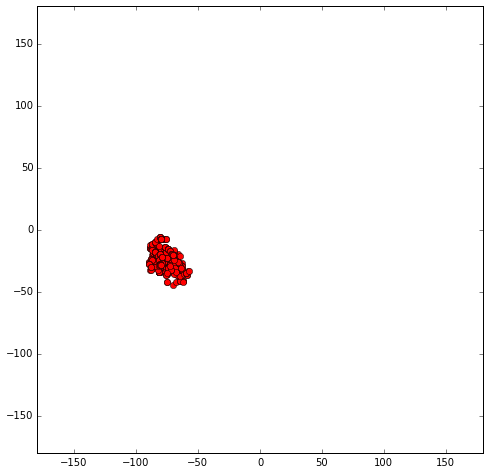

In [42]:
plt.figure(figsize=(8, 8))

for traj in storage.trajectories[1:]:
    phi_angles = np.array(phi(traj)).flatten() / deg
    psi_angles = np.array(psi(traj)).flatten() / deg
    plt.plot(phi_angles, psi_angles, 'ro', linewidth=1);
    
plt.xlim(-180, 180);
plt.ylim(-180, 180);

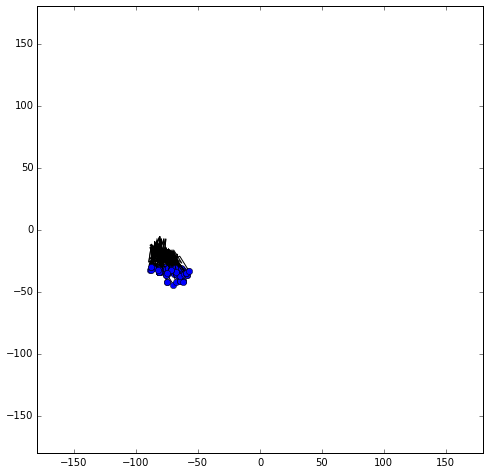

In [43]:
plt.figure(figsize=(8, 8))


for traj in storage.trajectories[1:]:
    phi_angles = np.array(phi(traj)).flatten() / deg
    psi_angles = np.array(psi(traj)).flatten() / deg
    plt.plot(phi_angles, psi_angles, 'k-', linewidth=1);
    for idx, snapshot in enumerate(traj):
        if opA(snapshot):
            plt.plot(phi_angles[idx], psi_angles[idx], 'bo', linewidth=1);
        
plt.xlim(-180, 180);
plt.ylim(-180, 180);